<a href="https://colab.research.google.com/github/FKz11/NN_PyTorch/blob/main/lesson_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lesson-3

### Библиотеки:

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## 1. Создать Dataset для загрузки данных

### Загрузка данных

In [ ]:
data = fetch_california_housing()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target[..., np.newaxis], test_size=0.25, shuffle=True, random_state=13)

In [ ]:
pd_train_data = pd.DataFrame(data=np.concatenate([X_train, y_train], axis=1), columns= data.feature_names + ["target"])
pd_train_data.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,3.5174,36.0,4.547945,1.094368,1357.0,2.065449,34.21,-118.23,2.680
1,2.9728,36.0,4.299465,0.997326,1217.0,3.254011,34.18,-118.37,1.902
2,1.6944,11.0,21.372093,4.627907,69.0,1.604651,40.19,-121.08,1.375
3,3.7143,49.0,6.201087,1.298913,505.0,2.744565,38.53,-122.94,1.488
4,2.9219,17.0,6.113960,1.128205,862.0,2.455840,38.73,-120.71,1.413


### EDA

In [ ]:
pd_train_data.dtypes

MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
target        float64
dtype: object

In [ ]:
pd_train_data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000
mean,3.861963,28.720284,5.425442,1.096577,1432.229651,3.107501,35.652980,-119.588727,2.066570
std,1.898655,12.570347,2.580798,0.494873,1150.630989,11.962527,2.148121,2.011185,1.151101
min,0.499900,1.000000,1.130435,0.333333,5.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.556200,18.000000,4.441059,1.006483,793.000000,2.430375,33.930000,-121.820000,1.198000
50%,3.523400,29.000000,5.226318,1.048338,1170.500000,2.820179,34.260000,-118.510000,1.799500
75%,4.740400,37.000000,6.046826,1.099367,1735.000000,3.279889,37.730000,-118.010000,2.649000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### Dataset для данных

In [ ]:
class DatasetHous(torch.utils.data.Dataset):
   
    X_scaler = None
    y_scaler = None

    def __init__(self, data, labels, train=True):
        self.data, self.labels = self.scaler(data, labels, train)

    @classmethod
    def scaler(cls, data, labels, train=True):
      if train:
          cls.X_scaler = StandardScaler()
          cls.X_scaler.fit(data)
          cls.y_scaler = StandardScaler()
          cls.y_scaler.fit(labels)
          labels = cls.y_scaler.transform(labels)

      return cls.X_scaler.transform(data), labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
train_dataset = DatasetHous(X_train, y_train, train=True)
test_dataset = DatasetHous(X_test, y_test, train=False)
train_dataset[0]

(array([-0.18148348,  0.57913684, -0.34002073, -0.00446324, -0.06538333,
        -0.08711252, -0.67176218,  0.67560682]), array([0.53292426]))

## 2. Обернуть его в Dataloader

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                          batch_size=8,
                          shuffle=False)
iter(test_loader).next()

[tensor([[ 0.1532, -1.0915,  0.2975, -0.2206, -0.5773,  0.0100, -0.1457,  0.2530],
         [-0.3355, -0.6142, -0.3528, -0.0412, -0.3661, -0.1027, -1.3282,  1.1728],
         [-0.4467, -0.8529,  0.4043,  0.5666, -0.1575, -0.0555, -0.7043,  1.7099],
         [-1.3652, -0.0573, -0.2916,  0.0725, -0.4374, -0.0499,  2.6801, -1.3829],
         [ 0.4270, -1.8075,  0.1181, -0.1278, -0.4026, -0.0143,  0.5386, -0.1399],
         [ 0.8725, -0.2960,  0.2344, -0.1602,  0.2058,  0.0422, -0.5647, -0.1498],
         [ 0.4053, -1.0120,  0.3647, -0.0360,  0.7594, -0.0489, -0.8068,  0.8894],
         [-0.1982, -0.0573, -0.3575, -0.1078,  0.6647,  0.1011, -0.8347,  0.8546]],
        dtype=torch.float64), tensor([[1.3010],
         [2.2940],
         [0.8260],
         [0.5310],
         [1.0780],
         [2.6830],
         [2.7750],
         [1.4280]], dtype=torch.float64)]

## 3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout

### Net

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, deep, dropout):
        super().__init__()
        self.fc = nn.ModuleList()
        self.bn = nn.ModuleList()

        self.fc.append(nn.Linear(input_dim, 2**(deep - 2) * hidden_dim))
        self.bn.append(nn.BatchNorm1d(2**(deep - 2) * hidden_dim))
        for i in range(1, deep - 1):
          self.fc.append(nn.Linear(2**(deep - 1 - i) * hidden_dim, 2**(deep - 2 - i) * hidden_dim))
          self.bn.append(nn.BatchNorm1d(2**(deep - 2 - i) * hidden_dim))
        self.fc.append(nn.Linear(hidden_dim, output_dim))

        self.dp = nn.Dropout(dropout)

    def forward(self, x):

        for i in range(len(self.bn)):
          x = self.fc[i](x)
          x = self.bn[i](x)
          x = torch.tanh(x)
          x = self.dp(x)

        x = self.fc[len(self.bn)](x)
        return x

### Train Net

In [ ]:
def net_train(train_loader, test_loader, num_epochs, hidden_dim, deep, dropout, optimiz, lr, noise):
  net = Net(8, 1, hidden_dim, deep, dropout).double()
  net.train()

  criterion = nn.MSELoss()

  if optimiz == 'adam':
    optimizer = optim.Adam(net.parameters(), lr=lr)

  if optimiz == 'rmsprop':
    optimizer = optim.RMSprop(net.parameters(), lr=lr)

  if optimiz == 'sgd':
    optimizer = optim.SGD(net.parameters(), lr=lr)

  train_loss_list = []

  for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    test_mse = 0.0

    for data in train_loader:

      inputs, labels = data[0], data[1]
      # Обнуляем градиент
      optimizer.zero_grad()
      # Делаем предсказание
      outputs = net(inputs)
      # Рассчитываем лосс-функцию
      loss = criterion(outputs, labels)
      # Делаем шаг назад по лоссу
      loss.backward()
      # Делаем шаг нашего оптимайзера
      optimizer.step()
      train_loss += loss.item()

    # Расчитываем loss на test
    for data in test_loader:
      inputs, labels = data[0], data[1]
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      test_loss += loss.item()

    # Расчитываем mse на test
      with torch.no_grad():
        outputs = DatasetHous.y_scaler.inverse_transform(outputs)
      outputs = torch.from_numpy(outputs)

      loss = criterion(outputs, labels)
      test_mse += loss.item()

    # выводим статистику о процессе обучения
    if noise:
      print(f'Epoch: {epoch + 1}; '\
            f'Train_loss: {round(train_loss / len(train_loader), 3)}; '\
            f'Test_loss: {round(test_loss / len(test_loader), 3)}; '\
            f'Test_MSE: {round(test_mse / len(test_loader), 3)}')
    
    train_loss_list.append(train_loss / len(train_loader))
  
  return net, round(test_mse / len(test_loader), 3), train_loss_list

In [ ]:
%%time

net = net_train(train_loader, test_loader, num_epochs=10, hidden_dim=40, 
                deep=4, dropout=0.1, optimiz='adam', lr=0.01, noise=True)[0]

Epoch: 1; Train_loss: 0.381; Test_loss: 5.033; Test_MSE: 0.619
Epoch: 2; Train_loss: 0.313; Test_loss: 5.128; Test_MSE: 0.597
Epoch: 3; Train_loss: 0.3; Test_loss: 4.883; Test_MSE: 0.587
Epoch: 4; Train_loss: 0.282; Test_loss: 4.956; Test_MSE: 0.601
Epoch: 5; Train_loss: 0.279; Test_loss: 4.887; Test_MSE: 0.573
Epoch: 6; Train_loss: 0.274; Test_loss: 5.093; Test_MSE: 0.565
Epoch: 7; Train_loss: 0.268; Test_loss: 4.76; Test_MSE: 0.584
Epoch: 8; Train_loss: 0.266; Test_loss: 5.033; Test_MSE: 0.573
Epoch: 9; Train_loss: 0.261; Test_loss: 5.144; Test_MSE: 0.589
Epoch: 10; Train_loss: 0.257; Test_loss: 4.996; Test_MSE: 0.584
CPU times: user 17.9 s, sys: 828 ms, total: 18.7 s
Wall time: 29.5 s


### hidden_dim

In [ ]:
%%time

hidden_dim_list = [10, 20, 30, 50, 100]

for hidden_dim in hidden_dim_list:
  print(hidden_dim, '-', net_train(train_loader, test_loader, num_epochs=10, hidden_dim=hidden_dim, 
                                   deep=4, dropout=0.1, optimiz='adam', lr=0.01, noise=False)[1])

10 - 0.625
20 - 0.6
30 - 0.573
50 - 0.595
100 - 0.57
CPU times: user 1min 8s, sys: 3.5 s, total: 1min 11s
Wall time: 1min 19s


### deep

In [ ]:
%%time

deep_list = [2, 3, 4, 5, 6]

for deep in deep_list:
  print(deep, '-', net_train(train_loader, test_loader, num_epochs=10, hidden_dim=30, 
                                   deep=deep, dropout=0.1, optimiz='adam', lr=0.01, noise=False)[1])

2 - 0.564
3 - 0.562
4 - 0.61
5 - 0.601
6 - 0.584
CPU times: user 1min 18s, sys: 3.68 s, total: 1min 22s
Wall time: 1min 38s


### dropout

In [ ]:
%%time

dropout_list = [0.0, 0.1, 0.2, 0.3, 0.5]

for dropout in dropout_list:
  print(dropout, '-', net_train(train_loader, test_loader, num_epochs=10, hidden_dim=30, 
                                   deep=3, dropout=dropout, optimiz='adam', lr=0.01, noise=False)[1])

0.0 - 0.541
0.1 - 0.571
0.2 - 0.57
0.3 - 0.584
0.5 - 0.683
CPU times: user 51.8 s, sys: 3.13 s, total: 55 s
Wall time: 1min 10s


### optimiz

In [ ]:
%%time

optimiz_list = ['adam', 'rmsprop', 'sgd']

for optimiz in optimiz_list:
  print(optimiz, '-', net_train(train_loader, test_loader, num_epochs=10, hidden_dim=30, 
                                   deep=3, dropout=0.0, optimiz=optimiz, lr=0.01, noise=False)[1])

adam - 0.547
rmsprop - 0.553
sgd - 0.589
CPU times: user 25.8 s, sys: 1.77 s, total: 27.6 s
Wall time: 31.8 s


### lr

In [ ]:
%%time

lr_list = [0.0001, 0.001, 0.01, 0.1, 1]

for lr in lr_list:
  print(lr, '-', net_train(train_loader, test_loader, num_epochs=10, hidden_dim=30, 
                                   deep=3, dropout=0.0, optimiz='adam', lr=lr, noise=False)[1])

0.0001 - 0.621
0.001 - 0.562
0.01 - 0.563
0.1 - 0.583
1 - 0.734
CPU times: user 44.3 s, sys: 3.06 s, total: 47.4 s
Wall time: 54.3 s


### Best model

In [ ]:
%%time

net = net_train(train_loader, test_loader, num_epochs=20, hidden_dim=30, 
                deep=3, dropout=0.0, optimiz='adam', lr=0.001, noise=True)[0]

Epoch: 1; Train_loss: 0.409; Test_loss: 5.021; Test_MSE: 0.643
Epoch: 2; Train_loss: 0.328; Test_loss: 4.922; Test_MSE: 0.588
Epoch: 3; Train_loss: 0.304; Test_loss: 4.902; Test_MSE: 0.594
Epoch: 4; Train_loss: 0.294; Test_loss: 4.904; Test_MSE: 0.576
Epoch: 5; Train_loss: 0.285; Test_loss: 4.802; Test_MSE: 0.599
Epoch: 6; Train_loss: 0.277; Test_loss: 4.837; Test_MSE: 0.6
Epoch: 7; Train_loss: 0.275; Test_loss: 4.829; Test_MSE: 0.561
Epoch: 8; Train_loss: 0.268; Test_loss: 4.815; Test_MSE: 0.56
Epoch: 9; Train_loss: 0.264; Test_loss: 4.781; Test_MSE: 0.58
Epoch: 10; Train_loss: 0.264; Test_loss: 4.931; Test_MSE: 0.556
Epoch: 11; Train_loss: 0.256; Test_loss: 4.852; Test_MSE: 0.564
Epoch: 12; Train_loss: 0.252; Test_loss: 4.897; Test_MSE: 0.556
Epoch: 13; Train_loss: 0.25; Test_loss: 4.89; Test_MSE: 0.557
Epoch: 14; Train_loss: 0.25; Test_loss: 4.852; Test_MSE: 0.552
Epoch: 15; Train_loss: 0.244; Test_loss: 4.875; Test_MSE: 0.558
Epoch: 16; Train_loss: 0.245; Test_loss: 4.915; Test_MSE

### 4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

In [ ]:
%%time

adam_mse = net_train(train_loader, test_loader, num_epochs=50, hidden_dim=30, 
                      deep=3, dropout=0.0, optimiz='adam', lr=0.001, noise=False)[2]

CPU times: user 44.2 s, sys: 2.93 s, total: 47.1 s
Wall time: 54.3 s


In [ ]:
%%time

rmsprop_mse = net_train(train_loader, test_loader, num_epochs=50, hidden_dim=30, 
                      deep=3, dropout=0.0, optimiz='rmsprop', lr=0.001, noise=False)[2]

CPU times: user 43.2 s, sys: 3.05 s, total: 46.3 s
Wall time: 53.8 s


In [ ]:
%%time

sgd_mse = net_train(train_loader, test_loader, num_epochs=50, hidden_dim=30, 
                      deep=3, dropout=0.0, optimiz='sgd', lr=0.001, noise=False)[2]

CPU times: user 41.1 s, sys: 3.13 s, total: 44.2 s
Wall time: 52.1 s


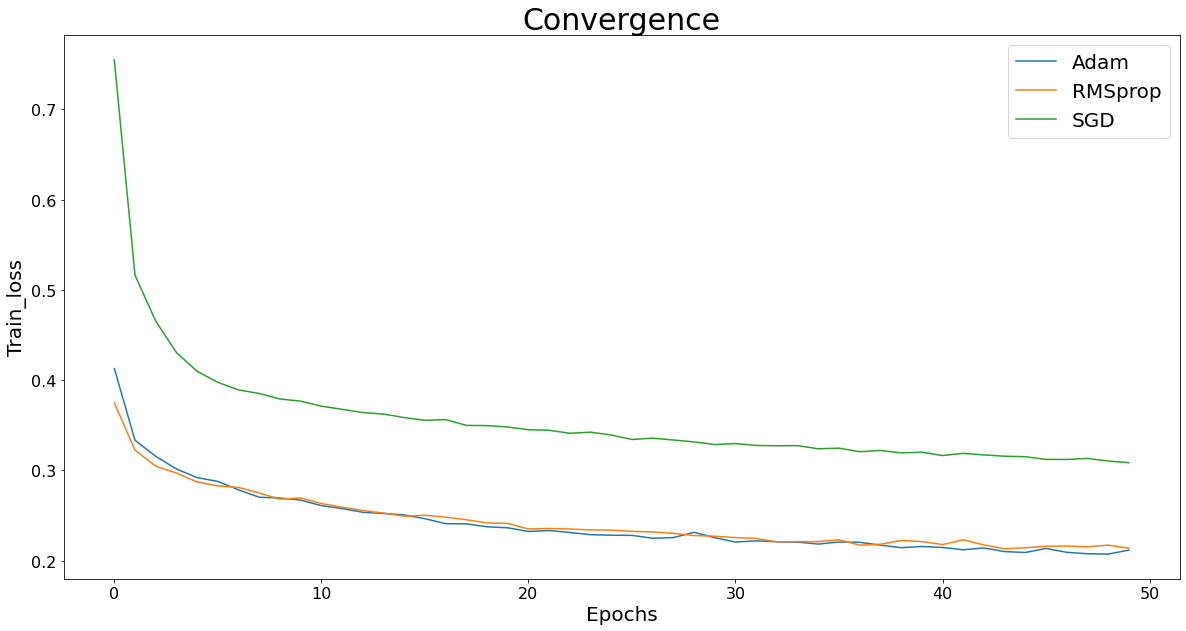

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Сonvergence", fontsize = 30)
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel("Train_loss", fontsize = 20)
plt.plot(adam_mse, label="Adam")
plt.plot(rmsprop_mse, label="RMSprop")
plt.plot(sgd_mse, label="SGD")
plt.legend(fontsize = 20)
plt.tick_params(labelsize=16)
plt.show()

### Вывод:

Я создал модель используя блоки: lin -> bn -> tanh -> drop -> lin.

Так как, как я прочитал, это один из оптимальных блоков. Например: drop до bn использовать плохо, потому что drop работает только при обучении, меняя статистические характеристики распределения, которые потом ищет bn. Поэтому на валидации результат будет плохим, так как drop отключается и bn получает истинные не изменённые характеристики распределения, которые он не ожидал.

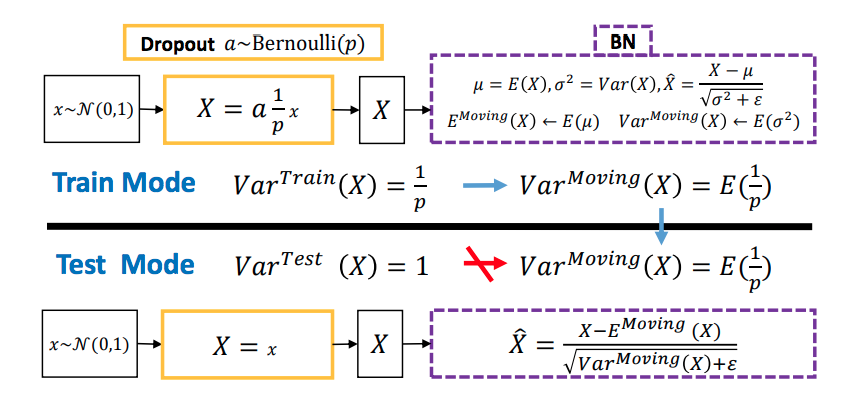

Я предварительно нормализовал все данные, а так же нормализовал таргет. Так как я попробывал и результаты оказались лучше, чем если таргет не нормализовывать и использывать ReLU или LeakyReLU. 0.7 MSE без нормализации таргета и 0.55 MSE с нормализацией.

Я думаю это из-за того, что у нас очень много BatchNorm в модели, и на выходе гораздо проще предсказывать величину из того же распределения, что и на входе. Хотя как мне кажется. это не очень хороший способ. Так как нам будет сложно добиться точных результатов, а не довольстоваться похожими.

Так же я поэкспериментировал с выведенными мною гиперпараметрами.
Оказалось, что drop в нашей сети является лишним, без него результат лучше, чем с ним. Наверное, BatchNorm в каждом блоке и так достаточно борется с переобучением, нормализуя данные на входе, из-за этого drop просто замедляет скорость обучения.

И сравнил сходимость оптимизаторов: Adam и RMSprop сходятся почти одинаково и заметно быстрее SGD. Так как у них для каждого веса своя скорость обучения, засчёт чего модель сходится быстрее и лучше. Чем чаще меняются веса, тем скорость обучения меньше, чем реже меняются веса, тем скорость обучения выше.


